## Preparation

### Download the optimization support library package

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 3.3 MB/s eta 0:00:00


### Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Libraries

In [3]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Temporal Convolutional Attention Networks models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

# Parameter optimization support library
import optuna

# Support library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Support library to load models and data
from keras.utils import custom_object_scope
from tensorflow.keras.models import load_model

## Data preprocessing

### Read data

In [4]:
# Load data
df = pd.read_csv('INTC.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,45.959999,47.470001,45.770000,47.080002,41.343937,18774600
1,2019-01-03,46.150002,46.279999,44.389999,44.490002,39.069477,32267300
2,2019-01-04,45.840000,47.570000,45.540001,47.220001,41.466869,35447300
3,2019-01-07,47.099998,48.000000,46.750000,47.439999,41.660065,22736800
4,2019-01-08,47.799999,48.029999,46.779999,47.740002,41.923512,22749200
...,...,...,...,...,...,...,...
1114,2023-06-06,29.770000,31.450001,29.700001,30.959999,30.959999,42295300
1115,2023-06-07,31.030001,31.370001,30.930000,31.280001,31.280001,39098000
1116,2023-06-08,31.430000,31.850000,31.059999,31.820000,31.820000,35199000
1117,2023-06-09,31.930000,31.990000,30.680000,31.340000,31.340000,40218000


### Reset index

In [5]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [6]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [7]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [8]:
# Split the data into train, validation, and test dataset in a ratio of 6:2:2
train_size = int(len(data_scaled) * 0.6)
val_size = int(len(data_scaled) * 0.2)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [9]:
# Generating data using the window sliding method
def create_dataset(data, window_size):
    windows, targets = [], []
    for i in range(len(data) - window_size):
        windows.append(data[i : (i + window_size), 0])
        targets.append(data[i + window_size, 0])
    return np.array(windows), np.array(targets)

### Building TCANs model

In [10]:
# Constructing sparse attention layer
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [11]:
# Build TCAN model
def build_tcan(window_size, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(window_size, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

### Learning process with combined parameter optimization

In [12]:
# Initialization of optimization parameters
best_mse = float('inf')
best_model = None
best_window_size = None
best_train_windows = None
best_train_targets = None
best_test_windows = None
best_test_targets = None
best_val_windows = None
best_val_targets = None
best_y_pred = None
best_mape = np.inf
best_rmse = np.inf
best_msle = np.inf

In [13]:
# Define the objective function for Optuna optimization
def objective(trial):
  global best_mse, best_model, best_window_size, best_train_windows
  global best_train_targets, best_test_windows, best_test_targets, best_val_windows
  global best_val_targets, best_y_pred, best_mape, best_rmse, best_msle

  # Define the search space for hyperparameters
  window_size = trial.suggest_int("window_size", 10, 100)
  tcn_filters = trial.suggest_int("tcn_filters", 32, 128)
  tcn_kernel_size = trial.suggest_int("tcn_kernel_size", 2, 5)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
  attention_dim = trial.suggest_int("attention_dim", 8, 32)

  # Build the TCAN model with the suggested hyperparameters
  model = build_tcan(window_size,
                     tcn_filters = tcn_filters,
                     tcn_kernel_size = tcn_kernel_size,
                     dropout_rate = dropout_rate,
                     attention_dim = attention_dim)

  train_windows, train_targets = create_dataset(train_data, window_size)
  test_windows, test_targets = create_dataset(test_data, window_size)
  val_windows, val_targets = create_dataset(val_data, window_size)

  # Train the model
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  model.fit(train_windows, train_targets,
            epochs=50, batch_size=32,
            validation_data=(val_windows, val_targets),
            shuffle=False, callbacks=[early_stop], verbose=0)

  # Testing the model on Test dataset
  y_pred = model.predict(test_windows)

  # Evaluate on MAPE, RMSE, MSLE
  temp_test_targets = test_targets
  temp_test_targets = scaler.inverse_transform(temp_test_targets.reshape(-1, 1))
  y_pred = scaler.inverse_transform(y_pred)

  mse = mean_squared_error(temp_test_targets, y_pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(temp_test_targets, y_pred)
  msle = mean_squared_log_error(temp_test_targets, y_pred)

  # Save the best model and related information
  if mse < best_mse or best_mse is None:
    best_model = model
    best_window_size = window_size
    best_y_pred = y_pred
    best_train_windows = train_windows
    best_train_targets = train_targets
    best_test_windows = test_windows
    best_test_targets = test_targets
    best_val_windows = val_windows
    best_val_targets = val_targets
    best_rmse = rmse
    best_mape = mape
    best_msle = msle
    best_mse = mse

  return mse

In [14]:
# Define the search space for the hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-06-14 15:21:48,355] A new study created in memory with name: no-name-0a23ee36-8d70-48cc-a2ae-6f3624161dcd


5/5 [==============================] - 1s 17ms/step


[I 2023-06-14 15:21:57,788] Trial 0 finished with value: 34.70309870614542 and parameters: {'window_size': 72, 'tcn_filters': 45, 'tcn_kernel_size': 3, 'dropout_rate': 0.10270657092185408, 'attention_dim': 13}. Best is trial 0 with value: 34.70309870614542.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 15:22:22,248] Trial 1 finished with value: 69.94781645818287 and parameters: {'window_size': 37, 'tcn_filters': 103, 'tcn_kernel_size': 2, 'dropout_rate': 0.3539616100195476, 'attention_dim': 15}. Best is trial 0 with value: 34.70309870614542.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 15:22:34,274] Trial 2 finished with value: 31.38418877477005 and parameters: {'window_size': 77, 'tcn_filters': 56, 'tcn_kernel_size': 3, 'dropout_rate': 0.17138584646084443, 'attention_dim': 27}. Best is trial 2 with value: 31.38418877477005.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:22:46,288] Trial 3 finished with value: 36.43576855430992 and parameters: {'window_size': 38, 'tcn_filters': 94, 'tcn_kernel_size': 4, 'dropout_rate': 0.48007155688654046, 'attention_dim': 29}. Best is trial 2 with value: 31.38418877477005.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 15:22:58,267] Trial 4 finished with value: 14.325477350914923 and parameters: {'window_size': 33, 'tcn_filters': 95, 'tcn_kernel_size': 2, 'dropout_rate': 0.11375514768440059, 'attention_dim': 9}. Best is trial 4 with value: 14.325477350914923.


5/5 [==============================] - 0s 14ms/step


[I 2023-06-14 15:23:21,213] Trial 5 finished with value: 11.162609008149463 and parameters: {'window_size': 86, 'tcn_filters': 108, 'tcn_kernel_size': 5, 'dropout_rate': 0.19483165673637914, 'attention_dim': 28}. Best is trial 5 with value: 11.162609008149463.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 15:23:34,024] Trial 6 finished with value: 97.14505853272223 and parameters: {'window_size': 59, 'tcn_filters': 66, 'tcn_kernel_size': 2, 'dropout_rate': 0.371665111539802, 'attention_dim': 27}. Best is trial 5 with value: 11.162609008149463.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 15:23:46,611] Trial 7 finished with value: 27.40524208327737 and parameters: {'window_size': 60, 'tcn_filters': 62, 'tcn_kernel_size': 3, 'dropout_rate': 0.1715553876859655, 'attention_dim': 12}. Best is trial 5 with value: 11.162609008149463.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 15:23:59,054] Trial 8 finished with value: 16.42705234925014 and parameters: {'window_size': 96, 'tcn_filters': 74, 'tcn_kernel_size': 5, 'dropout_rate': 0.24462184526661745, 'attention_dim': 13}. Best is trial 5 with value: 11.162609008149463.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:24:12,961] Trial 9 finished with value: 7.921644120627369 and parameters: {'window_size': 63, 'tcn_filters': 74, 'tcn_kernel_size': 5, 'dropout_rate': 0.11680061385448699, 'attention_dim': 8}. Best is trial 9 with value: 7.921644120627369.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:24:19,532] Trial 10 finished with value: 18.194753976037596 and parameters: {'window_size': 18, 'tcn_filters': 120, 'tcn_kernel_size': 4, 'dropout_rate': 0.2725406804050686, 'attention_dim': 21}. Best is trial 9 with value: 7.921644120627369.


4/4 [==============================] - 0s 15ms/step


[I 2023-06-14 15:24:57,824] Trial 11 finished with value: 20.345353321163905 and parameters: {'window_size': 100, 'tcn_filters': 119, 'tcn_kernel_size': 5, 'dropout_rate': 0.18702362560239633, 'attention_dim': 21}. Best is trial 9 with value: 7.921644120627369.


5/5 [==============================] - 0s 18ms/step


[I 2023-06-14 15:25:20,895] Trial 12 finished with value: 10.262913842020945 and parameters: {'window_size': 82, 'tcn_filters': 83, 'tcn_kernel_size': 5, 'dropout_rate': 0.21645613376095024, 'attention_dim': 32}. Best is trial 9 with value: 7.921644120627369.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 15:25:36,415] Trial 13 finished with value: 8.065666691079674 and parameters: {'window_size': 71, 'tcn_filters': 83, 'tcn_kernel_size': 4, 'dropout_rate': 0.10701739367087185, 'attention_dim': 32}. Best is trial 9 with value: 7.921644120627369.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 15:25:44,595] Trial 14 finished with value: 68.08310269627859 and parameters: {'window_size': 50, 'tcn_filters': 34, 'tcn_kernel_size': 4, 'dropout_rate': 0.13995076471135917, 'attention_dim': 18}. Best is trial 9 with value: 7.921644120627369.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 15:26:07,032] Trial 15 finished with value: 5.138507064684986 and parameters: {'window_size': 68, 'tcn_filters': 82, 'tcn_kernel_size': 4, 'dropout_rate': 0.10088821889389425, 'attention_dim': 24}. Best is trial 15 with value: 5.138507064684986.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:26:22,236] Trial 16 finished with value: 35.70515666147419 and parameters: {'window_size': 51, 'tcn_filters': 76, 'tcn_kernel_size': 5, 'dropout_rate': 0.15165194390402498, 'attention_dim': 22}. Best is trial 15 with value: 5.138507064684986.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 15:26:44,692] Trial 17 finished with value: 63.54293145069649 and parameters: {'window_size': 66, 'tcn_filters': 51, 'tcn_kernel_size': 4, 'dropout_rate': 0.22223313666746694, 'attention_dim': 24}. Best is trial 15 with value: 5.138507064684986.


6/6 [==============================] - 0s 9ms/step


[I 2023-06-14 15:26:57,295] Trial 18 finished with value: 6.2205057273044195 and parameters: {'window_size': 46, 'tcn_filters': 88, 'tcn_kernel_size': 5, 'dropout_rate': 0.10080355066080221, 'attention_dim': 17}. Best is trial 15 with value: 5.138507064684986.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 15:27:10,145] Trial 19 finished with value: 21.572556264668368 and parameters: {'window_size': 26, 'tcn_filters': 91, 'tcn_kernel_size': 4, 'dropout_rate': 0.1450984793601657, 'attention_dim': 18}. Best is trial 15 with value: 5.138507064684986.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 15:27:34,070] Trial 20 finished with value: 36.419039130429425 and parameters: {'window_size': 47, 'tcn_filters': 109, 'tcn_kernel_size': 3, 'dropout_rate': 0.25551019968941624, 'attention_dim': 24}. Best is trial 15 with value: 5.138507064684986.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:27:45,993] Trial 21 finished with value: 7.999813859744841 and parameters: {'window_size': 63, 'tcn_filters': 70, 'tcn_kernel_size': 5, 'dropout_rate': 0.10306938720305919, 'attention_dim': 9}. Best is trial 15 with value: 5.138507064684986.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:27:59,378] Trial 22 finished with value: 13.05762407817161 and parameters: {'window_size': 44, 'tcn_filters': 83, 'tcn_kernel_size': 5, 'dropout_rate': 0.13459938897270946, 'attention_dim': 17}. Best is trial 15 with value: 5.138507064684986.


6/6 [==============================] - 0s 13ms/step


[I 2023-06-14 15:28:21,832] Trial 23 finished with value: 11.711194943817048 and parameters: {'window_size': 55, 'tcn_filters': 88, 'tcn_kernel_size': 5, 'dropout_rate': 0.15015980115703217, 'attention_dim': 24}. Best is trial 15 with value: 5.138507064684986.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:28:28,428] Trial 24 finished with value: 7.827839604367135 and parameters: {'window_size': 10, 'tcn_filters': 101, 'tcn_kernel_size': 4, 'dropout_rate': 0.13269361425835505, 'attention_dim': 8}. Best is trial 15 with value: 5.138507064684986.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:28:40,507] Trial 25 finished with value: 25.739119673624554 and parameters: {'window_size': 11, 'tcn_filters': 101, 'tcn_kernel_size': 4, 'dropout_rate': 0.1745020989830375, 'attention_dim': 11}. Best is trial 15 with value: 5.138507064684986.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 15:28:52,369] Trial 26 finished with value: 27.54973755457411 and parameters: {'window_size': 25, 'tcn_filters': 111, 'tcn_kernel_size': 4, 'dropout_rate': 0.20611882973926773, 'attention_dim': 16}. Best is trial 15 with value: 5.138507064684986.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:28:59,016] Trial 27 finished with value: 10.106574502170428 and parameters: {'window_size': 11, 'tcn_filters': 101, 'tcn_kernel_size': 3, 'dropout_rate': 0.10070870239497529, 'attention_dim': 19}. Best is trial 15 with value: 5.138507064684986.


5/5 [==============================] - 1s 21ms/step


[I 2023-06-14 15:29:20,929] Trial 28 finished with value: 10.830611707962621 and parameters: {'window_size': 88, 'tcn_filters': 128, 'tcn_kernel_size': 4, 'dropout_rate': 0.14214607541779414, 'attention_dim': 15}. Best is trial 15 with value: 5.138507064684986.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 15:29:33,255] Trial 29 finished with value: 10.42145899835049 and parameters: {'window_size': 71, 'tcn_filters': 88, 'tcn_kernel_size': 3, 'dropout_rate': 0.12858637631317124, 'attention_dim': 14}. Best is trial 15 with value: 5.138507064684986.


7/7 [==============================] - 0s 8ms/step


[I 2023-06-14 15:29:43,235] Trial 30 finished with value: 16.073277830491456 and parameters: {'window_size': 26, 'tcn_filters': 97, 'tcn_kernel_size': 4, 'dropout_rate': 0.16639082094424512, 'attention_dim': 10}. Best is trial 15 with value: 5.138507064684986.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 15:30:05,592] Trial 31 finished with value: 3.2172226766363647 and parameters: {'window_size': 66, 'tcn_filters': 77, 'tcn_kernel_size': 5, 'dropout_rate': 0.10113399926248279, 'attention_dim': 8}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 15:30:20,343] Trial 32 finished with value: 11.267469851152962 and parameters: {'window_size': 78, 'tcn_filters': 79, 'tcn_kernel_size': 5, 'dropout_rate': 0.12677421445103565, 'attention_dim': 8}. Best is trial 31 with value: 3.2172226766363647.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 15:30:32,497] Trial 33 finished with value: 8.651762237313164 and parameters: {'window_size': 41, 'tcn_filters': 67, 'tcn_kernel_size': 5, 'dropout_rate': 0.10076934052226469, 'attention_dim': 11}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 15:30:47,361] Trial 34 finished with value: 21.740983887521143 and parameters: {'window_size': 68, 'tcn_filters': 61, 'tcn_kernel_size': 4, 'dropout_rate': 0.16639094557150688, 'attention_dim': 26}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 15:31:09,737] Trial 35 finished with value: 8.222056988612716 and parameters: {'window_size': 76, 'tcn_filters': 91, 'tcn_kernel_size': 5, 'dropout_rate': 0.1259754324542784, 'attention_dim': 13}. Best is trial 31 with value: 3.2172226766363647.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:31:32,485] Trial 36 finished with value: 18.73688282464178 and parameters: {'window_size': 33, 'tcn_filters': 105, 'tcn_kernel_size': 4, 'dropout_rate': 0.18669306650803963, 'attention_dim': 10}. Best is trial 31 with value: 3.2172226766363647.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:31:55,917] Trial 37 finished with value: 16.94864975000235 and parameters: {'window_size': 56, 'tcn_filters': 98, 'tcn_kernel_size': 2, 'dropout_rate': 0.12415830637480783, 'attention_dim': 23}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 15:32:12,791] Trial 38 finished with value: 7.844415285549211 and parameters: {'window_size': 89, 'tcn_filters': 115, 'tcn_kernel_size': 3, 'dropout_rate': 0.1510186222342729, 'attention_dim': 30}. Best is trial 31 with value: 3.2172226766363647.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:32:24,897] Trial 39 finished with value: 15.449437404933079 and parameters: {'window_size': 18, 'tcn_filters': 87, 'tcn_kernel_size': 5, 'dropout_rate': 0.120026786597258, 'attention_dim': 26}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 15:32:47,450] Trial 40 finished with value: 22.370909657156012 and parameters: {'window_size': 75, 'tcn_filters': 54, 'tcn_kernel_size': 4, 'dropout_rate': 0.15993208014732704, 'attention_dim': 20}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 15ms/step


[I 2023-06-14 15:33:02,836] Trial 41 finished with value: 11.76835566237107 and parameters: {'window_size': 90, 'tcn_filters': 115, 'tcn_kernel_size': 3, 'dropout_rate': 0.146389971164137, 'attention_dim': 29}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 15:33:22,603] Trial 42 finished with value: 16.255853731304676 and parameters: {'window_size': 83, 'tcn_filters': 94, 'tcn_kernel_size': 3, 'dropout_rate': 0.11658129982019318, 'attention_dim': 29}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 15:33:41,700] Trial 43 finished with value: 5.883679293923212 and parameters: {'window_size': 91, 'tcn_filters': 127, 'tcn_kernel_size': 2, 'dropout_rate': 0.1013032681713296, 'attention_dim': 30}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 15:33:53,430] Trial 44 finished with value: 10.120188818289138 and parameters: {'window_size': 95, 'tcn_filters': 70, 'tcn_kernel_size': 2, 'dropout_rate': 0.10148298699971611, 'attention_dim': 26}. Best is trial 31 with value: 3.2172226766363647.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 15:34:06,386] Trial 45 finished with value: 14.45825290562721 and parameters: {'window_size': 37, 'tcn_filters': 78, 'tcn_kernel_size': 2, 'dropout_rate': 0.11962098415659174, 'attention_dim': 12}. Best is trial 31 with value: 3.2172226766363647.


7/7 [==============================] - 0s 8ms/step


[I 2023-06-14 15:34:15,452] Trial 46 finished with value: 14.979033760919837 and parameters: {'window_size': 32, 'tcn_filters': 128, 'tcn_kernel_size': 2, 'dropout_rate': 0.17828050734534812, 'attention_dim': 31}. Best is trial 31 with value: 3.2172226766363647.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 15:34:25,957] Trial 47 finished with value: 23.361597018574695 and parameters: {'window_size': 60, 'tcn_filters': 63, 'tcn_kernel_size': 5, 'dropout_rate': 0.19356257178806377, 'attention_dim': 8}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 15:34:39,035] Trial 48 finished with value: 10.73638518035002 and parameters: {'window_size': 66, 'tcn_filters': 73, 'tcn_kernel_size': 4, 'dropout_rate': 0.13478218502504305, 'attention_dim': 28}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 25ms/step


[I 2023-06-14 15:34:59,280] Trial 49 finished with value: 8.370892340065351 and parameters: {'window_size': 80, 'tcn_filters': 124, 'tcn_kernel_size': 5, 'dropout_rate': 0.11588775388624092, 'attention_dim': 22}. Best is trial 31 with value: 3.2172226766363647.


4/4 [==============================] - 0s 10ms/step


[I 2023-06-14 15:35:19,894] Trial 50 finished with value: 20.57098009825928 and parameters: {'window_size': 100, 'tcn_filters': 82, 'tcn_kernel_size': 4, 'dropout_rate': 0.16022036915881974, 'attention_dim': 15}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 15:35:37,136] Trial 51 finished with value: 7.169528058494626 and parameters: {'window_size': 93, 'tcn_filters': 118, 'tcn_kernel_size': 3, 'dropout_rate': 0.10082058899346946, 'attention_dim': 30}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 15:35:55,679] Trial 52 finished with value: 9.498800367378665 and parameters: {'window_size': 92, 'tcn_filters': 122, 'tcn_kernel_size': 2, 'dropout_rate': 0.11418514774994229, 'attention_dim': 31}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 15:36:38,718] Trial 53 finished with value: 23.782570800866214 and parameters: {'window_size': 85, 'tcn_filters': 116, 'tcn_kernel_size': 3, 'dropout_rate': 0.10078040595974802, 'attention_dim': 27}. Best is trial 31 with value: 3.2172226766363647.


4/4 [==============================] - 0s 9ms/step


[I 2023-06-14 15:37:01,993] Trial 54 finished with value: 10.562042209251686 and parameters: {'window_size': 97, 'tcn_filters': 106, 'tcn_kernel_size': 2, 'dropout_rate': 0.13540305092298704, 'attention_dim': 9}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 16ms/step


[I 2023-06-14 15:37:24,583] Trial 55 finished with value: 6.006088084367588 and parameters: {'window_size': 73, 'tcn_filters': 124, 'tcn_kernel_size': 3, 'dropout_rate': 0.11459191906254612, 'attention_dim': 25}. Best is trial 31 with value: 3.2172226766363647.


6/6 [==============================] - 0s 14ms/step


[I 2023-06-14 15:37:36,909] Trial 56 finished with value: 10.749659486548888 and parameters: {'window_size': 54, 'tcn_filters': 119, 'tcn_kernel_size': 3, 'dropout_rate': 0.11283916527379932, 'attention_dim': 28}. Best is trial 31 with value: 3.2172226766363647.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 15:37:59,622] Trial 57 finished with value: 17.692273386840665 and parameters: {'window_size': 64, 'tcn_filters': 124, 'tcn_kernel_size': 3, 'dropout_rate': 0.14913923070258006, 'attention_dim': 25}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 15:38:12,390] Trial 58 finished with value: 19.299022719286985 and parameters: {'window_size': 69, 'tcn_filters': 112, 'tcn_kernel_size': 3, 'dropout_rate': 0.31650206399767894, 'attention_dim': 30}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 15:38:23,640] Trial 59 finished with value: 39.56163428378817 and parameters: {'window_size': 74, 'tcn_filters': 36, 'tcn_kernel_size': 3, 'dropout_rate': 0.11234330724722412, 'attention_dim': 22}. Best is trial 31 with value: 3.2172226766363647.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:38:45,930] Trial 60 finished with value: 14.18387522863834 and parameters: {'window_size': 49, 'tcn_filters': 125, 'tcn_kernel_size': 2, 'dropout_rate': 0.1399309077762052, 'attention_dim': 32}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 15:39:05,196] Trial 61 finished with value: 10.58028568242469 and parameters: {'window_size': 92, 'tcn_filters': 86, 'tcn_kernel_size': 4, 'dropout_rate': 0.10310337956658829, 'attention_dim': 20}. Best is trial 31 with value: 3.2172226766363647.


6/6 [==============================] - 0s 13ms/step


[I 2023-06-14 15:39:18,438] Trial 62 finished with value: 7.939314945116567 and parameters: {'window_size': 58, 'tcn_filters': 118, 'tcn_kernel_size': 3, 'dropout_rate': 0.13754195365621755, 'attention_dim': 28}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 15:39:41,260] Trial 63 finished with value: 5.894864055981929 and parameters: {'window_size': 80, 'tcn_filters': 91, 'tcn_kernel_size': 4, 'dropout_rate': 0.12665097149504637, 'attention_dim': 30}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 15:39:56,113] Trial 64 finished with value: 8.025708252093215 and parameters: {'window_size': 80, 'tcn_filters': 92, 'tcn_kernel_size': 5, 'dropout_rate': 0.1257815890651063, 'attention_dim': 30}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 15:40:18,424] Trial 65 finished with value: 16.734327537346775 and parameters: {'window_size': 73, 'tcn_filters': 76, 'tcn_kernel_size': 4, 'dropout_rate': 0.15804052247158468, 'attention_dim': 31}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 15:40:31,774] Trial 66 finished with value: 9.076112422772644 and parameters: {'window_size': 85, 'tcn_filters': 71, 'tcn_kernel_size': 5, 'dropout_rate': 0.11194726584956188, 'attention_dim': 25}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 15:40:50,133] Trial 67 finished with value: 50.12974794311066 and parameters: {'window_size': 78, 'tcn_filters': 81, 'tcn_kernel_size': 3, 'dropout_rate': 0.1278490205323924, 'attention_dim': 27}. Best is trial 31 with value: 3.2172226766363647.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 15:41:02,172] Trial 68 finished with value: 4.750505619479705 and parameters: {'window_size': 61, 'tcn_filters': 84, 'tcn_kernel_size': 4, 'dropout_rate': 0.10028786222050877, 'attention_dim': 29}. Best is trial 31 with value: 3.2172226766363647.


6/6 [==============================] - 0s 12ms/step


[I 2023-06-14 15:41:14,419] Trial 69 finished with value: 11.185661591551975 and parameters: {'window_size': 62, 'tcn_filters': 84, 'tcn_kernel_size': 4, 'dropout_rate': 0.14063393909593555, 'attention_dim': 18}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 15:41:37,644] Trial 70 finished with value: 23.16702669330353 and parameters: {'window_size': 70, 'tcn_filters': 79, 'tcn_kernel_size': 4, 'dropout_rate': 0.17277363401557289, 'attention_dim': 23}. Best is trial 31 with value: 3.2172226766363647.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:41:50,611] Trial 71 finished with value: 10.073694800682787 and parameters: {'window_size': 53, 'tcn_filters': 89, 'tcn_kernel_size': 4, 'dropout_rate': 0.10092687159996061, 'attention_dim': 29}. Best is trial 31 with value: 3.2172226766363647.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 15:42:12,975] Trial 72 finished with value: 14.768649355373814 and parameters: {'window_size': 43, 'tcn_filters': 121, 'tcn_kernel_size': 5, 'dropout_rate': 0.11225426077182353, 'attention_dim': 30}. Best is trial 31 with value: 3.2172226766363647.


6/6 [==============================] - 0s 12ms/step


[I 2023-06-14 15:42:23,735] Trial 73 finished with value: 9.162294258492258 and parameters: {'window_size': 64, 'tcn_filters': 75, 'tcn_kernel_size': 4, 'dropout_rate': 0.12566638867911845, 'attention_dim': 28}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 15:42:34,010] Trial 74 finished with value: 9.35797598363392 and parameters: {'window_size': 67, 'tcn_filters': 85, 'tcn_kernel_size': 4, 'dropout_rate': 0.10969921403750003, 'attention_dim': 32}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 15:42:56,383] Trial 75 finished with value: 6.049052235917638 and parameters: {'window_size': 82, 'tcn_filters': 95, 'tcn_kernel_size': 5, 'dropout_rate': 0.12450207678049796, 'attention_dim': 27}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 15:43:17,006] Trial 76 finished with value: 10.731226210746337 and parameters: {'window_size': 82, 'tcn_filters': 96, 'tcn_kernel_size': 5, 'dropout_rate': 0.14683407332370965, 'attention_dim': 27}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 15:43:59,878] Trial 77 finished with value: 21.80731629831016 and parameters: {'window_size': 73, 'tcn_filters': 98, 'tcn_kernel_size': 5, 'dropout_rate': 0.12992352786545092, 'attention_dim': 25}. Best is trial 31 with value: 3.2172226766363647.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 15:44:24,050] Trial 78 finished with value: 10.180820598394432 and parameters: {'window_size': 58, 'tcn_filters': 93, 'tcn_kernel_size': 5, 'dropout_rate': 0.12009039035508282, 'attention_dim': 26}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 15:44:39,912] Trial 79 finished with value: 9.84917406187568 and parameters: {'window_size': 87, 'tcn_filters': 90, 'tcn_kernel_size': 5, 'dropout_rate': 0.15960846981217416, 'attention_dim': 17}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 15:45:02,323] Trial 80 finished with value: 18.489870103339754 and parameters: {'window_size': 77, 'tcn_filters': 67, 'tcn_kernel_size': 5, 'dropout_rate': 0.13590028943777638, 'attention_dim': 29}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 23ms/step


[I 2023-06-14 15:45:24,889] Trial 81 finished with value: 7.241986999275383 and parameters: {'window_size': 94, 'tcn_filters': 128, 'tcn_kernel_size': 5, 'dropout_rate': 0.10724674706587264, 'attention_dim': 31}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 15:45:48,023] Trial 82 finished with value: 11.317150724448243 and parameters: {'window_size': 83, 'tcn_filters': 77, 'tcn_kernel_size': 4, 'dropout_rate': 0.11960453513105629, 'attention_dim': 29}. Best is trial 31 with value: 3.2172226766363647.


4/4 [==============================] - 0s 10ms/step


[I 2023-06-14 15:46:04,179] Trial 83 finished with value: 13.404016624219691 and parameters: {'window_size': 97, 'tcn_filters': 112, 'tcn_kernel_size': 2, 'dropout_rate': 0.10835143606818831, 'attention_dim': 28}. Best is trial 31 with value: 3.2172226766363647.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 15:46:16,770] Trial 84 finished with value: 8.373949635117693 and parameters: {'window_size': 61, 'tcn_filters': 103, 'tcn_kernel_size': 3, 'dropout_rate': 0.10146806856366149, 'attention_dim': 30}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 17ms/step


[I 2023-06-14 15:46:39,290] Trial 85 finished with value: 9.650991028500162 and parameters: {'window_size': 71, 'tcn_filters': 82, 'tcn_kernel_size': 5, 'dropout_rate': 0.12396428320232065, 'attention_dim': 24}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 1s 8ms/step


[I 2023-06-14 15:47:02,412] Trial 86 finished with value: 6.113471143891584 and parameters: {'window_size': 91, 'tcn_filters': 88, 'tcn_kernel_size': 4, 'dropout_rate': 0.13234439972992312, 'attention_dim': 27}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 15:47:30,297] Trial 87 finished with value: 26.214809700480775 and parameters: {'window_size': 90, 'tcn_filters': 87, 'tcn_kernel_size': 4, 'dropout_rate': 0.15315891669121887, 'attention_dim': 27}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 15:47:53,019] Trial 88 finished with value: 16.972840380844566 and parameters: {'window_size': 80, 'tcn_filters': 95, 'tcn_kernel_size': 4, 'dropout_rate': 0.1333356342465285, 'attention_dim': 26}. Best is trial 31 with value: 3.2172226766363647.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:48:05,901] Trial 89 finished with value: 18.751410694294062 and parameters: {'window_size': 48, 'tcn_filters': 85, 'tcn_kernel_size': 4, 'dropout_rate': 0.14451024974706944, 'attention_dim': 23}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 15:48:18,197] Trial 90 finished with value: 7.123795682568751 and parameters: {'window_size': 66, 'tcn_filters': 80, 'tcn_kernel_size': 4, 'dropout_rate': 0.11811664986166587, 'attention_dim': 19}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 15:48:28,093] Trial 91 finished with value: 8.022282218418962 and parameters: {'window_size': 66, 'tcn_filters': 80, 'tcn_kernel_size': 4, 'dropout_rate': 0.11495827379402317, 'attention_dim': 19}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 15:48:43,393] Trial 92 finished with value: 7.161377691981924 and parameters: {'window_size': 69, 'tcn_filters': 89, 'tcn_kernel_size': 4, 'dropout_rate': 0.12117773004744542, 'attention_dim': 21}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 15:48:56,034] Trial 93 finished with value: 7.4293774631452205 and parameters: {'window_size': 76, 'tcn_filters': 73, 'tcn_kernel_size': 4, 'dropout_rate': 0.13114169483150134, 'attention_dim': 19}. Best is trial 31 with value: 3.2172226766363647.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:49:08,630] Trial 94 finished with value: 7.910118425485938 and parameters: {'window_size': 52, 'tcn_filters': 92, 'tcn_kernel_size': 4, 'dropout_rate': 0.11111738892760994, 'attention_dim': 17}. Best is trial 31 with value: 3.2172226766363647.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:49:31,969] Trial 95 finished with value: 20.333607759174967 and parameters: {'window_size': 56, 'tcn_filters': 83, 'tcn_kernel_size': 4, 'dropout_rate': 0.1436912107872857, 'attention_dim': 25}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 15:49:54,492] Trial 96 finished with value: 8.778926139778555 and parameters: {'window_size': 72, 'tcn_filters': 99, 'tcn_kernel_size': 5, 'dropout_rate': 0.12007247684562519, 'attention_dim': 14}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 15:50:17,482] Trial 97 finished with value: 10.80635830069094 and parameters: {'window_size': 65, 'tcn_filters': 78, 'tcn_kernel_size': 4, 'dropout_rate': 0.1066982372995951, 'attention_dim': 28}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 15:50:29,829] Trial 98 finished with value: 7.193968628629935 and parameters: {'window_size': 88, 'tcn_filters': 80, 'tcn_kernel_size': 4, 'dropout_rate': 0.13074813260999, 'attention_dim': 21}. Best is trial 31 with value: 3.2172226766363647.


5/5 [==============================] - 0s 14ms/step


[I 2023-06-14 15:50:52,355] Trial 99 finished with value: 10.978286853970879 and parameters: {'window_size': 68, 'tcn_filters': 87, 'tcn_kernel_size': 5, 'dropout_rate': 0.12046837126495037, 'attention_dim': 27}. Best is trial 31 with value: 3.2172226766363647.


In [15]:
# Display the optimal set of parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'window_size': 66, 'tcn_filters': 77, 'tcn_kernel_size': 5, 'dropout_rate': 0.10113399926248279, 'attention_dim': 8}


In [16]:
# Evaluate the accuracy of test
print(f"MAPE on Test dataset: ", best_mape)
print(f"RMSE on Test dataset: ", best_rmse)
print(f"MSLE on Test dataset: ", best_msle)

MAPE on Test dataset:  0.048188087572779675
RMSE on Test dataset:  1.7936618066503967
MSLE on Test dataset:  0.0037075079458506613


### Save and Load the best model and related information

In [17]:
# Save the best model and related information
best_model.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_model.h5')

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_window_size.npy', best_window_size)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_train_windows.npy', best_train_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_train_targets.npy', best_train_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_test_windows.npy', best_test_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_test_targets.npy', best_test_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_val_windows.npy', best_val_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_val_targets.npy', best_val_targets)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_y_pred.npy', best_y_pred)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_mse.npy', best_mse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_rmse.npy', best_rmse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_mape.npy', best_mape)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_msle.npy', best_msle)

In [18]:
# Load the best model and related information
with custom_object_scope({'AttentionLayer': AttentionLayer}):
    loaded_best_model = load_model('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_model.h5')

loaded_best_window_size = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_window_size.npy')
loaded_best_train_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_train_windows.npy')
loaded_best_train_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_train_targets.npy')
loaded_best_test_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_test_windows.npy')
loaded_best_test_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_test_targets.npy')
loaded_best_val_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_val_windows.npy')
loaded_best_val_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_val_targets.npy')

loaded_best_y_pred = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_y_pred.npy')

loaded_best_mse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_mse.npy').item()
loaded_best_rmse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_rmse.npy').item()
loaded_best_mape = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_mape.npy').item()
loaded_best_msle = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/6:2:2/best_msle.npy').item()

## Predicting the next 30 days

### Preparing the forecast date index

In [19]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Prediction process

In [20]:
# Predict the closing price for the next 30 days
last_sequence_days = np.array(data_scaled[-loaded_best_window_size:]).reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = loaded_best_model.predict(last_sequence_days)

    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])

    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 32ms/step


In [21]:
print('Predicted closing prices for the next 30 days:')
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1))
print(y_next_30_days.flatten())

Predicted closing prices for the next 30 days:
[31.864264 31.890575 31.682846 31.393246 31.202929 30.999245 30.815475
 30.652487 30.524162 30.431023 30.351673 30.290827 30.301071 30.35078
 30.409405 30.479294 30.54694  30.58361  30.62031  30.630934 30.628773
 30.595495 30.584703 30.554365 30.574741 30.567747 30.538134 30.515585
 30.477352 30.422443]


## Visualization

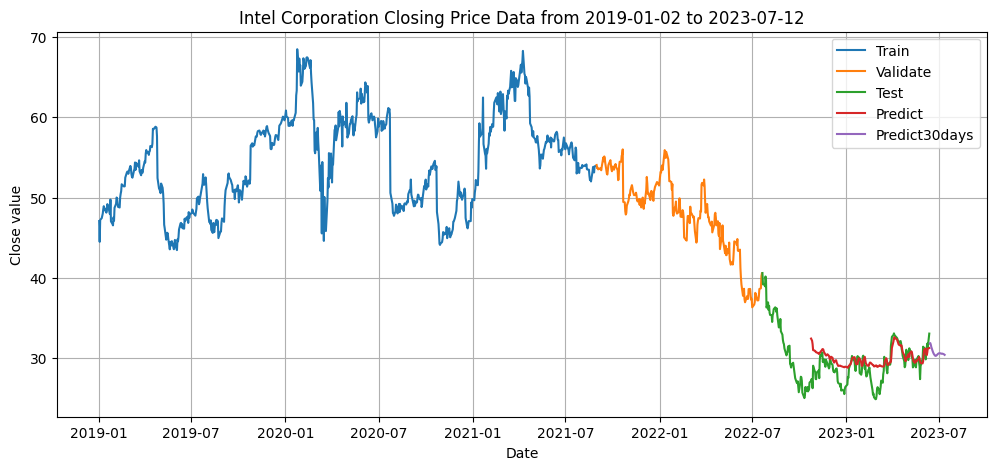

In [22]:
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size + loaded_best_window_size: ], loaded_best_y_pred)

plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'Test', 'Predict', 'Predict30days'])

plt.grid()
plt.title(f"Intel Corporation Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('TCAN_622_INTC.png')
plt.show()